In [1]:
import os 
import pandas as pd 
import spacy 
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image  
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter
import sys
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import statistics
import torchvision.models as models

torch.backends.cudnn.benchmark = True

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Building Vocabulary

In [3]:
spacy_eng = spacy.load("en_core_web_sm")

def getNumberOfParameter(model):
    print('Number of trainable params: ', sum(p.numel() for p in model.parameters() if p.requires_grad))
    print('Total params: ', sum(p.numel() for p in model.parameters()))

class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [self.stoi[token] if token in self.stoi else self.stoi["<UNK>"] for token in tokenized_text]

# Preparing Datasets

In [4]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, choose_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        
        self.df = pd.read_csv(captions_file, sep='\t', names=['image', 'caption'])
        self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
        
        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.df["caption"].tolist())
                
        self.choose_df = pd.read_csv(choose_file, names=['image'])
            
        self.df = self.df.loc[self.df['image'].isin(self.choose_df['image'].values)].reset_index(drop=True)
        
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.new('RGB', (RESIZE,RESIZE))
        try:
            img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")
        except:
            print(img_id)

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)



In [5]:
class MyCollate:
    def __init__(self, pad_idx, batch_first):
        self.pad_idx = pad_idx
        self.batch_first = batch_first

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=self.batch_first, padding_value=self.pad_idx)
        
        return imgs, targets

In [6]:
def get_loader(
    root_folder,
    annotation_file,
    choose_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True
):
    dataset = FlickrDataset(root_folder, annotation_file, choose_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset = dataset,
        batch_size = batch_size,
        num_workers = num_workers,
        shuffle = shuffle,
        pin_memory = pin_memory,
        collate_fn = MyCollate(pad_idx=pad_idx,batch_first = True),
    )

    return loader, dataset

# Encoder - CNN

In [7]:
class EncoderCNN(nn.Module):
    def __init__(self, train_CNN):
        super(EncoderCNN, self).__init__()
        self.train_CNN = train_CNN
        
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        
        # Fine tune
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Only train last 2 layers of resnet if at all required
        if train_CNN:
            for c in list(self.resnet.children())[-2:]:
                for p in c.parameters():
                    p.requires_grad = trainCNN
        

    def forward(self, images):
        features = self.resnet(images) 
        features = features.permute(0, 2, 3, 1) # batch, 7, 7, 2048
        features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
        return features

# Attention

In [8]:
class Attention(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super(Attention, self).__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)  
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)  # linear layer to calculate values to be softmax-ed
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)
        att2 = self.decoder_att(decoder_hidden)
        
        combined_states = self.tanh(att1 + att2.unsqueeze(1))
        
        att = self.full_att(combined_states).squeeze(2)  # (batch_size, num_pixels)
        alpha = self.softmax(att)  # (batch_size, num_pixels)
        
        attention_weighted_encoding = encoder_out * alpha.unsqueeze(2)   # (batch_size, encoder_dim)
        attention_weighted_encoding = attention_weighted_encoding.sum(dim=1)  

        return alpha, attention_weighted_encoding


# Decoder - LSTM

In [9]:
#Attention Decoder
class DecoderRNN(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,drop_prob=0.3):
        super().__init__()
        
        #save the model param
        self.vocab_size = vocab_size
        self.attention_dim = attention_dim
        self.decoder_dim = decoder_dim
        
        self.embedding = nn.Embedding(vocab_size,embed_size)
        self.attention = Attention(encoder_dim,decoder_dim,attention_dim)
        
        
        self.init_h = nn.Linear(encoder_dim, decoder_dim)  
        self.init_c = nn.Linear(encoder_dim, decoder_dim)  
        self.lstm_cell = nn.LSTMCell(embed_size+encoder_dim,decoder_dim,bias=True)
        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        
        
        self.fcn = nn.Linear(decoder_dim,vocab_size)
        self.drop = nn.Dropout(drop_prob)
        
        
    
    def forward(self, features, captions):
        
        #vectorize the caption
        embeds = self.embedding(captions)
        
        # Initialize LSTM state
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        #get the seq length to iterate
        seq_length = len(captions[0])-1 #Exclude the last one
        batch_size = captions.size(0)
        num_features = features.size(1)
        
        preds = torch.zeros(batch_size, seq_length, self.vocab_size).to(device)
        alphas = torch.zeros(batch_size, seq_length,num_features).to(device)
                
        for s in range(seq_length):
            alpha,context = self.attention(features, h)
            lstm_input = torch.cat((embeds[:, s], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
                    
            output = self.fcn(self.drop(h))
            
            preds[:,s] = output
            alphas[:,s] = alpha  
        
        
        return preds, alphas
    
    def generate_caption(self,features,max_len=20,vocab=None):
        # Inference part
        # Given the image features generate the captions
        
        batch_size = features.size(0)
        h, c = self.init_hidden_state(features)  # (batch_size, decoder_dim)
        
        alphas = []
        
        #starting input
        word = torch.tensor(vocab.stoi['<SOS>']).view(1,-1).to(device)
        embeds = self.embedding(word)

        
        captions = []
        
        for i in range(max_len):
            alpha,context = self.attention(features, h)
            
            
            #store the apla score
            alphas.append(alpha.cpu().detach().numpy())
            
            lstm_input = torch.cat((embeds[:, 0], context), dim=1)
            h, c = self.lstm_cell(lstm_input, (h, c))
            output = self.fcn(self.drop(h))
            output = output.view(batch_size,-1)
        
            
            #select the word with most val
            predicted_word_idx = output.argmax(dim=1)
            
            #save the generated word
            captions.append(predicted_word_idx.item())
            
            #end if <EOS detected>
            if vocab.itos[predicted_word_idx.item()] == "<EOS>":
                break
            
            #send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))
        
        #covert the vocab idx to words and return sentence
        return [vocab.itos[idx] for idx in captions],alphas
    
    
    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = self.init_h(mean_encoder_out)  # (batch_size, decoder_dim)
        c = self.init_c(mean_encoder_out)
        return h, c

In [10]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)


def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    step = checkpoint["step"]
    return step

In [11]:
class EncoderDecoder(nn.Module):
    def __init__(self,embed_size, vocab_size, attention_dim,encoder_dim,decoder_dim,train_CNN,drop_prob=0.3):
        super().__init__()
        self.encoder = EncoderCNN(train_CNN)
        self.decoder = DecoderRNN(
            embed_size=embed_size,
            vocab_size = len(dataset.vocab),
            attention_dim=attention_dim,
            encoder_dim=encoder_dim,
            decoder_dim=decoder_dim
        )
        
    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

In [12]:
RESIZE = 226
CROP = 224

In [13]:
# get the losses for vizualization
losses = list()
val_losses = list()
# Train the model
batch_size=256
#Preprocessing and Augmentation on Image Data
transform = transforms.Compose(
    [
        transforms.Resize((RESIZE, RESIZE)),
        transforms.RandomCrop((CROP, CROP)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225)),
    ]
)
train_loader, dataset = get_loader(
    '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr8k.token.txt',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.trainImages.txt',
    transform=transform,
    num_workers=4,
    batch_size=batch_size,
    shuffle=True
)

val_loader, val_dataset = get_loader(
    '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr8k.token.txt',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.valImages.txt',
    transform=transform,
    num_workers=4,
    batch_size=batch_size,
    shuffle=True
)

/tmp/ipykernel_27/4036121523.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/tmp/ipykernel_27/4036121523.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
/opt/conda/lib/python3.10/site-packages/tor

# Hyperparameters

In [14]:
#Hyperparams
embed_size=300
vocab_size = len(dataset.vocab)
attention_dim=256
encoder_dim=2048
decoder_dim=512
learning_rate = 3e-4
train_CNN = False
load_model = False
save_model = True

# Initializing the Model

In [15]:
#initialize model, loss etc
model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    train_CNN=train_CNN
).to(device)

criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s] 


In [16]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':len(dataset.vocab),
        'attention_dim':attention_dim,
        'encoder_dim':encoder_dim,
        'decoder_dim':decoder_dim,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'attention_model_state.pth')

# Training

In [17]:
num_epochs = 25
print_every = 100
step = 0

for epoch in range(1,num_epochs+1):
    model.train()
    total_loss = 0.0
    if save_model:
            checkpoint = {
                "state_dict": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "step": step,
            }
            save_checkpoint(checkpoint)
            torch.save(model.state_dict(), 'puremodel.pth.tar')

    for idx, (image, captions) in tqdm(
            enumerate(train_loader), total=len(train_loader), leave=False):
        image,captions = image.to(device),captions.to(device)

        # Zero the gradients.
        optimizer.zero_grad()

        # Feed forward
        outputs,attentions = model(image, captions)

        # Calculate the batch loss.
        targets = captions[:,1:]
        loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
        
        step += 1
        # Backward pass.
        loss.backward()

        # Update the parameters in the optimizer.
        optimizer.step()
        
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print("Epoch: {} Training Loss: {:.5f}".format(epoch,avg_loss))
            

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for idx, (image, captions) in tqdm(
            enumerate(val_loader), total=len(val_loader), leave=False):
            image,captions = image.to(device),captions.to(device)

            outputs,attentions = model(image, captions)

            # Calculate the batch loss.
            targets = captions[:,1:]
            loss = criterion(outputs.view(-1, vocab_size), targets.reshape(-1))
            val_loss += loss.item()
            
    average_val_loss = val_loss / len(val_loader)
    print("Epoch: {} Validation Loss: {:.5f}".format(epoch,average_val_loss))
    #save the latest model
    save_model(model,epoch)

=> Saving checkpoint


Epoch: 1 Training Loss: 4.76131


Epoch: 1 Validation Loss: 4.11386
=> Saving checkpoint


Epoch: 2 Training Loss: 3.84884


Epoch: 2 Validation Loss: 3.63569
=> Saving checkpoint


Epoch: 3 Training Loss: 3.47086


Epoch: 3 Validation Loss: 3.37943
=> Saving checkpoint


Epoch: 4 Training Loss: 3.24610


Epoch: 4 Validation Loss: 3.21672
=> Saving checkpoint


Epoch: 5 Training Loss: 3.08544


Epoch: 5 Validation Loss: 3.11370
=> Saving checkpoint


Epoch: 6 Training Loss: 2.96334


Epoch: 6 Validation Loss: 3.02539
=> Saving checkpoint


Epoch: 7 Training Loss: 2.86918


Epoch: 7 Validation Loss: 2.96481
=> Saving checkpoint


Epoch: 8 Training Loss: 2.78368


Epoch: 8 Validation Loss: 2.90905
=> Saving checkpoint


Epoch: 9 Training Loss: 2.71237


Epoch: 9 Validation Loss: 2.87030
=> Saving checkpoint


Epoch: 10 Training Loss: 2.64733


Epoch: 10 Validation Loss: 2.83670
=> Saving checkpoint


Epoch: 11 Training Loss: 2.58960


Epoch: 11 Validation Loss: 2.80678
=> Saving checkpoint


Epoch: 12 Training Loss: 2.53760


Epoch: 12 Validation Loss: 2.78202
=> Saving checkpoint


Epoch: 13 Training Loss: 2.48973


Epoch: 13 Validation Loss: 2.76093
=> Saving checkpoint


Epoch: 14 Training Loss: 2.44587


Epoch: 14 Validation Loss: 2.74728
=> Saving checkpoint


Epoch: 15 Training Loss: 2.40242


Epoch: 15 Validation Loss: 2.73374
=> Saving checkpoint


Epoch: 16 Training Loss: 2.36303


Epoch: 16 Validation Loss: 2.71672
=> Saving checkpoint


Epoch: 17 Training Loss: 2.32530


Epoch: 17 Validation Loss: 2.70721
=> Saving checkpoint


Epoch: 18 Training Loss: 2.28879


Epoch: 18 Validation Loss: 2.69968
=> Saving checkpoint


Epoch: 19 Training Loss: 2.25445


Epoch: 19 Validation Loss: 2.68991
=> Saving checkpoint


Epoch: 20 Training Loss: 2.22335


Epoch: 20 Validation Loss: 2.68774
=> Saving checkpoint


Epoch: 21 Training Loss: 2.19401


Epoch: 21 Validation Loss: 2.67849
=> Saving checkpoint


Epoch: 22 Training Loss: 2.16301


Epoch: 22 Validation Loss: 2.67513
=> Saving checkpoint


Epoch: 23 Training Loss: 2.13743


Epoch: 23 Validation Loss: 2.67290
=> Saving checkpoint


Epoch: 24 Training Loss: 2.10362


Epoch: 24 Validation Loss: 2.67222
=> Saving checkpoint


Epoch: 25 Training Loss: 2.07979


Epoch: 25 Validation Loss: 2.66538


# Predicting Captions for Test Dataset

In [33]:
test_loader, test_dataset = get_loader(
    '/kaggle/input/flikerdata/Flickr8K/Flicker8k_Images',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr8k.token.txt',
    '/kaggle/input/flikerdata/Flickr8K/Flickr8k_text/Flickr_8k.testImages.txt',
    transform=transform,
    num_workers=4,
    shuffle=False
)

model = EncoderDecoder(
    embed_size=embed_size,
    vocab_size = vocab_size,
    attention_dim=attention_dim,
    encoder_dim=encoder_dim,
    decoder_dim=decoder_dim,
    train_CNN=train_CNN
).to(device)
model.load_state_dict(torch.load("./my_checkpoint.pth.tar")['state_dict'])
#model.load_state_dict(torch.load("../input/flickr8k/my_checkpoint.pth.tar")['state_dict'])
model.eval()

predicted_captions = []
i = 0
for idx, (imgs, captions) in tqdm(
            enumerate(test_loader), total=len(test_loader), leave=False
        ):
    for k in range(imgs.shape[0]):
        img = imgs[k].unsqueeze(0)
        real_caption = [dataset.vocab.itos[j.item()] for j in captions[k]]
        features = model.encoder(img[0:1].to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        predicted_captions.append([caption,real_caption])
        i += 1

/tmp/ipykernel_27/4036121523.py:6: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  self.df['image'] = self.df["image"].str.split('#', 1, expand=True)[0]
/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_util

In [52]:
captions = []
for x in predicted_captions:
    k = 0
    s = ""
    while x[1][k] != '<EOS>':
        if x[1][k] != '<SOS>':
            s += x[1][k]
            s += ' '
        k +=1
    s += '<EOS>'     
    captions.append([x[0],s])

In [58]:
i = 0
references_corpus = []
candidate_corpus = []
for e in captions:
    references_corpus.append(e[1])
    candidate_corpus.append(e[0])

0.0


In [63]:
len(candidate_corpus)

5000

In [74]:
import nltk

In [82]:
from nltk.translate.bleu_score import sentence_bleu

# BLEU Score

In [87]:
total_bleu_score = 0
num_sentences = len(references_corpus)

for ref_sent, gen_sent in zip(references_corpus, candidate_corpus):
    gen_tokens = gen_sent.split()  # Use appropriate tokenization here
    ref_tokens = ref_sent.split()  # Wrap the reference tokens in a list
    
    # Calculate BLEU score
    bleu_score_value = sentence_bleu(ref_tokens,gen_tokens)
    total_bleu_score += bleu_score_value

average_bleu_score = total_bleu_score / num_sentences
print("Average BLEU score:", average_bleu_score)

Average BLEU score: 0.6284772048423983


In [78]:
!pip install nltk==3.5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.0 MB/s eta 0:00:0000:010:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434693 sha256=3bea1200761f5f5fe72ee44cd3ae2e668c161a0df36bf938c4b4c8908b354bb6
  Stored in directory: /root/.cache/pip/wheels/35/ab/82/f9667f6f884d272670a15382599a9c753a1dfdc83f7412e37d
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Successfully uninstalled nltk-3.8.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.5 which is incompatible.


In [81]:
for ref_sent, gen_sent in zip(references_corpus, candidate_corpus):    
    # Calculate METEOR score
    score_value = nltk.translate.meteor_score.meteor_score(ref_sent, gen_sent)
    total_score += score_value

average_score = total_score / num_sentences
print("Average METEOR score:", average_score)

AttributeError: module 'nltk.translate' has no attribute 'meteor_score'

In [92]:
import matplotlib.pyplot as plt
def show_image(img, title=None):
    """Imshow for Tensor."""
    
    #unnormalize 
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    
    
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [93]:
#generate caption
def get_caps_from(features_tensors):
    #generate the caption
    model.eval()
    with torch.no_grad():
        features = model.encoder(features_tensors.to(device))
        caps,alphas = model.decoder.generate_caption(features,vocab=dataset.vocab)
        caption = ' '.join(caps)
        show_image(features_tensors[0],title=caption)
    
    return caps,alphas

#Show attention
def plot_attention(img, result, attention_plot):
    #untransform
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    
    img = img.numpy().transpose((1, 2, 0))
    temp_image = img

    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)
        
        ax = fig.add_subplot(len_result//2,len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())
        

    plt.tight_layout()
    plt.show()

# Visualizing the Attention

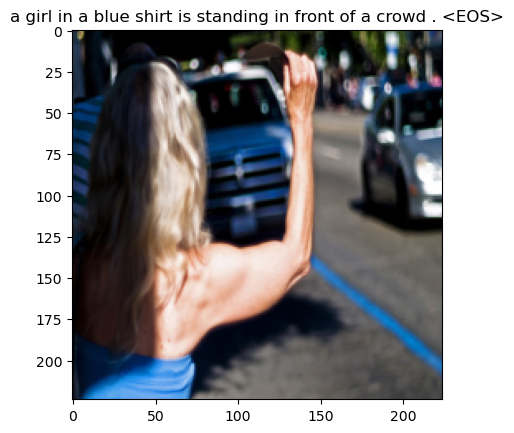

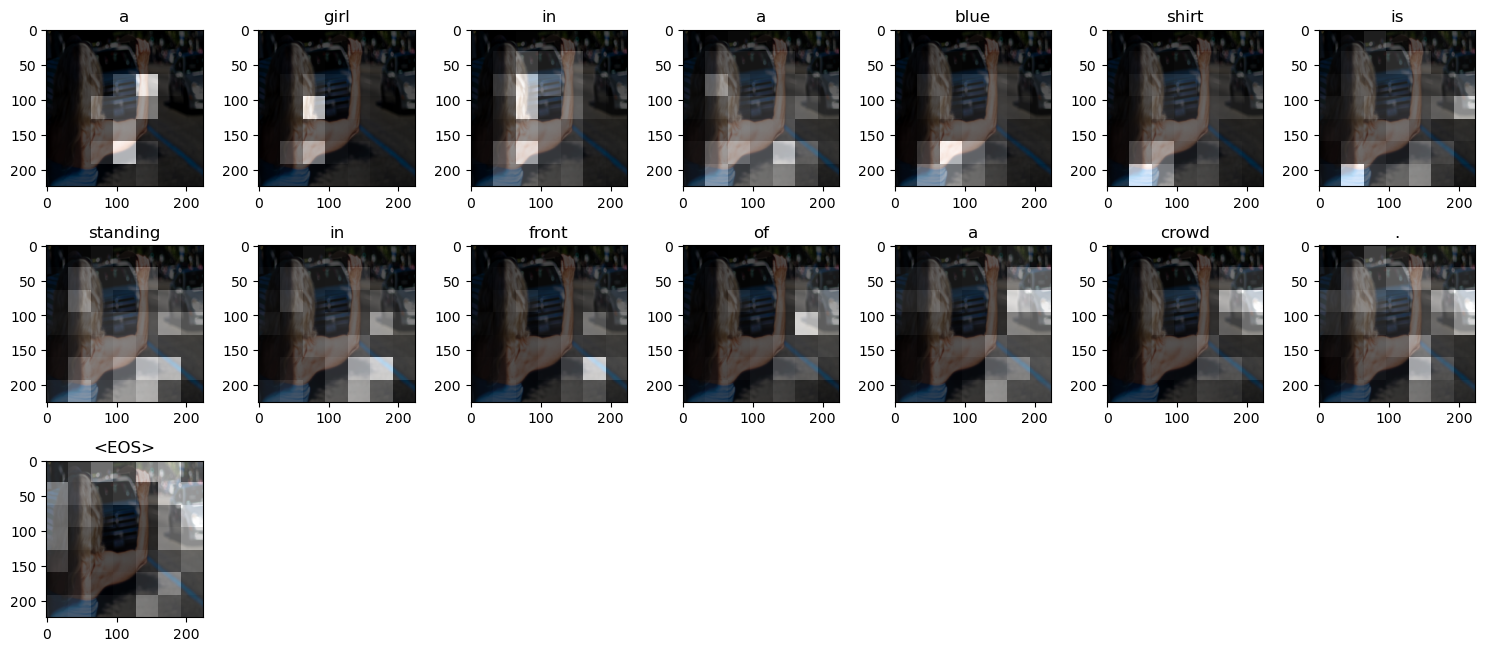

In [96]:
#show any 1
dataiter = iter(test_loader)
images,_ = next(dataiter)

img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

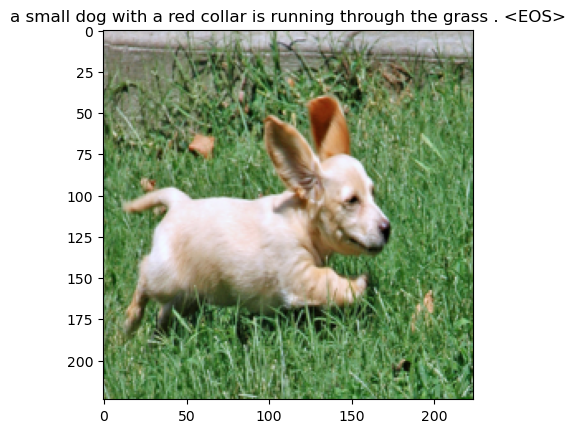

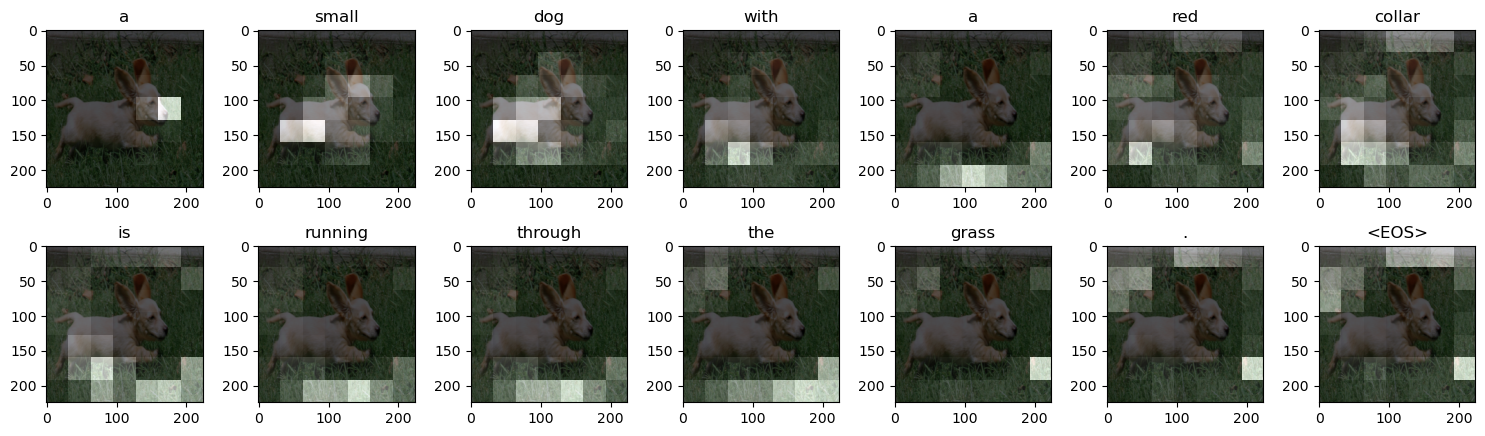

In [98]:
#show any 1
dataiter = iter(test_loader)
images,_ = next(dataiter)
images,_ = next(dataiter)
images,_ = next(dataiter)
img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)

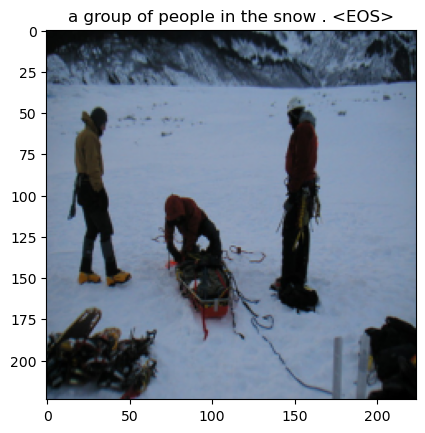

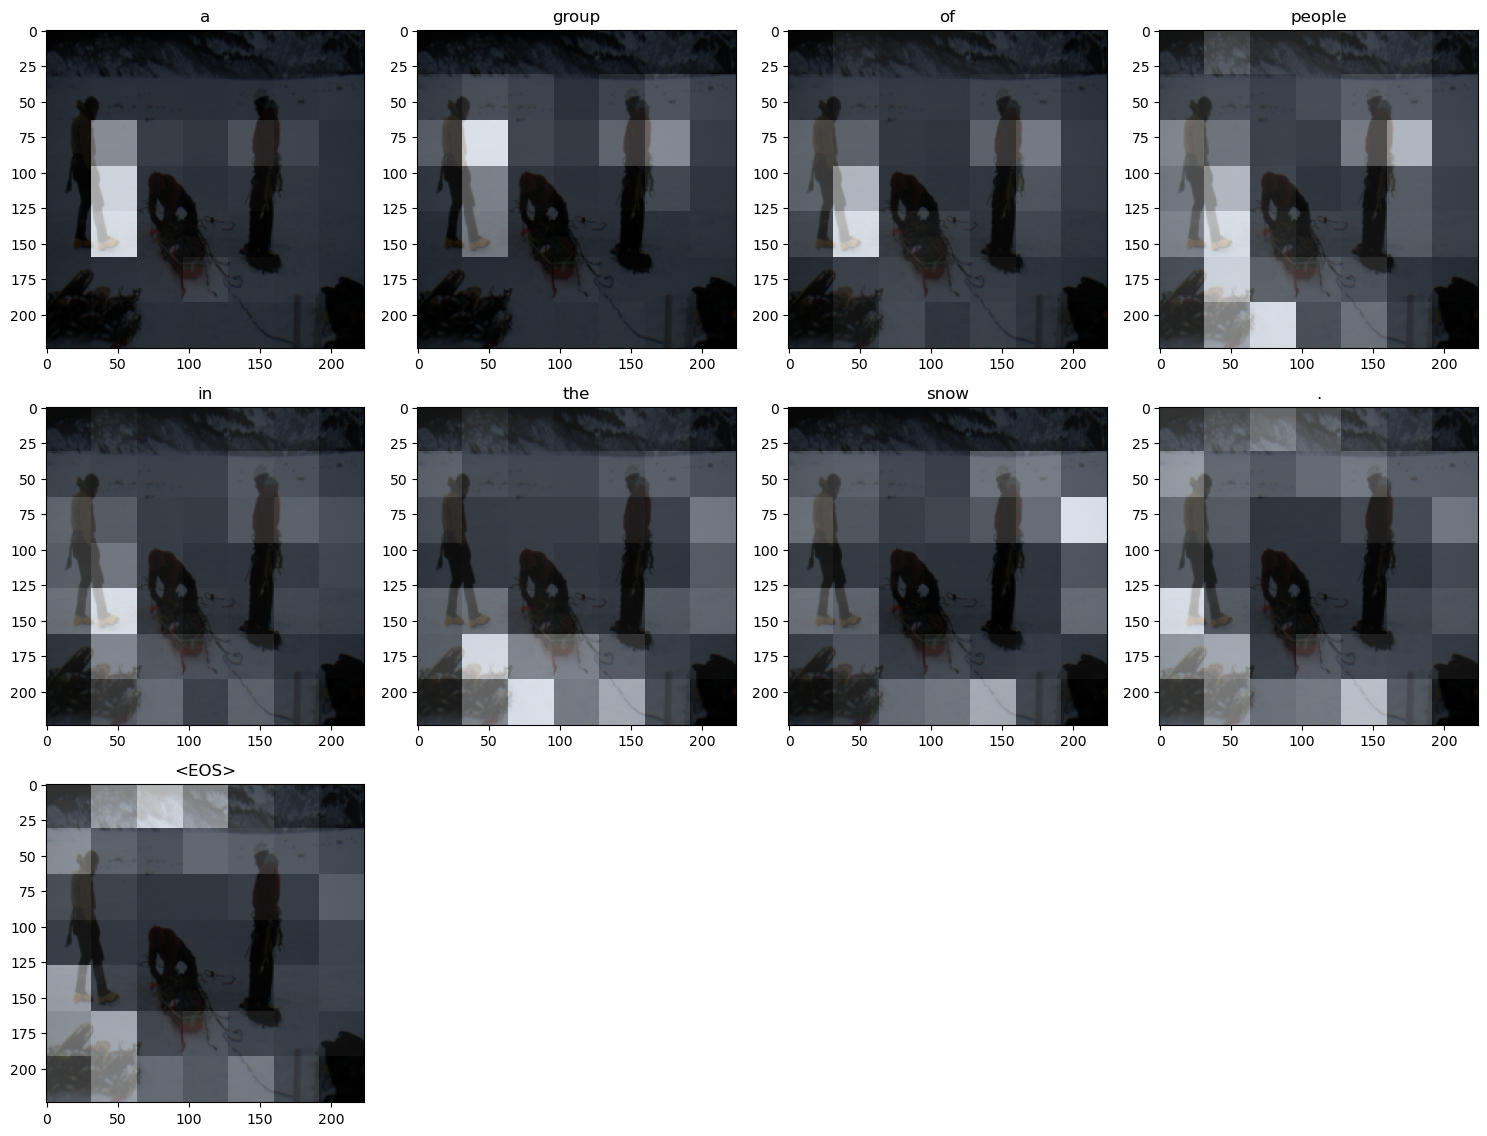

In [99]:
#show any 1
dataiter = iter(test_loader)
images,_ = next(dataiter)
images,_ = next(dataiter)
images,_ = next(dataiter)
img = images[0].detach().clone()
img1 = images[0].detach().clone()
caps,alphas = get_caps_from(img.unsqueeze(0))

plot_attention(img1, caps, alphas)